<img src="../assets/cover_image_PT6.png"/>
---

# Case Study in NLP

Copyright, NLP from scratch, 2024.

[NLPfor.me](https://www.nlpfor.me)

------------

In this notebook, we will work through a case study in NLP. You are working with a client which has a website for reviews of products and services, and the product manager on the business side has come with the following ask:

> As we continue to receive an increasing volume of customer feedback on our website, it has become evident that manual categorization of reviews is not only time-consuming but also prone to errors. To improve our efficiency, enhance the overall user experience, and better utilize customer insights, leadership is proposing we develop a machine learning model to automatically categorize reviews into three primary categories: retail, restaurants, and movies, as these make up our largest categories of reviews and searches.

We will work through developing an MVP for the above business problem. Let's get started!

## Data Loading and Exploration



First we will import the "holy trinity" of data science in Python: [numpy](https://numpy.org) for working with numeric data, [pandas](https://pandas.pydata.org/) for working with structured data, and [matplotlib](https://matplotlib.org) for data visualization.

For working with processing text data and doing machine learning (with [scikit-learn](https://scikit-learn.org)), we will import the relevant modules and classes as needed.

In [1]:
# Holy trinity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Next we will read in the data we will be working with. To build an MVP model, we will be using a dataset which is a combination of reviews from Amazon.com (for retail products / electronics), Rottentomatoes (for movies), and Yelp (for restaurants). This data is available on the [NLP from scratch datasets github repo](https://github.com/nlpfromscratch/datasets/tree/master/amazon_rt_yelp).

We can read the data in directly with `pd.read_csv`, as it can retrieve files directly from a URL! There is no need to download it:

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/nlpfromscratch/datasets/refs/heads/master/amazon_rt_yelp/amazon_rt_yelp.csv')

Let's take a look at what we are working with:

In [3]:
df.head()

,text,source
0,I picked up a jar of fresh-made salsa and chip...,yelp
1,The husband and I had driven by Hula's multipl...,yelp
2,Had some amazing cuisine at Milagro's. The che...,yelp
3,Chill coffee bar. That is the best way to desc...,yelp
4,Fancy shop with great kitchen items that I wo...,yelp


We can see we have two columns, `text`, which has the free-form review text, and a `source` column which appears to have a text description of the source.

In [4]:
df.shape

(15000, 2)

There are 15,000 reviews in the dataset. What are the distinct values in the `source` column?

In [5]:
df['source'].unique()

array(['yelp', 'rottentomatoes', 'amazon'], dtype=object)

Let's dive deeper here and check if the distribution of different review types is uniform:

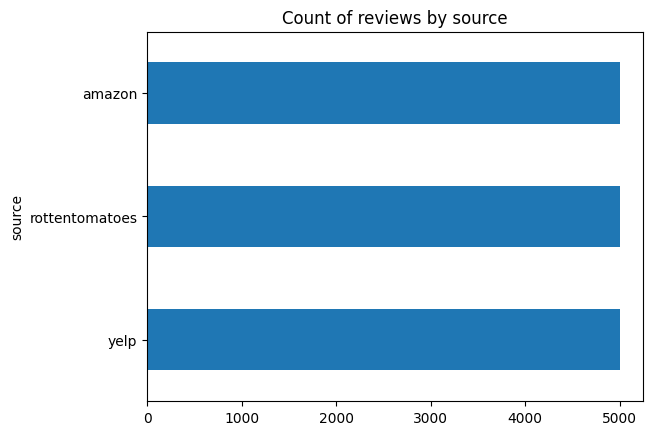

In [6]:
plt.figure()
df['source'].value_counts().plot(kind='barh')
plt.title('Count of reviews by source')
plt.show()

It is, we have 5K reviews for each of the three different review types (amazon, rottentomatoes, and yelp). There is not too much else to be done in terms of exploratory data analysis as we only have text and categorical features, but let's take a look at the length of the reviews and their distribution:

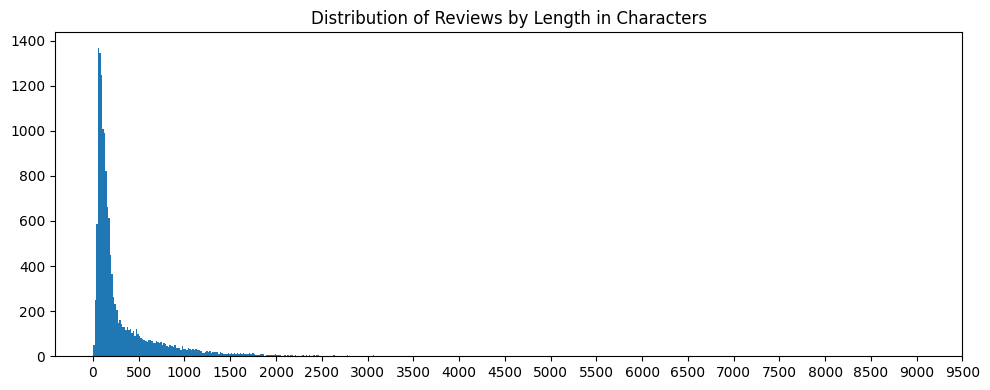

In [7]:
plt.figure(figsize=(10,4))
df['text'].str.len().hist(bins=500, grid=False)
plt.xticks(np.arange(0, 10000, 500))
plt.title('Distribution of Reviews by Length in Characters')
plt.tight_layout()
plt.show()

We can see the review lengths are not normally distributed but follow a very long-tailed distribution with the vast majority of reviews being between 0-500 characters in length.

## Data preprocessing and transformation

Now that we have taken a look at the data we are working with, we will clean and preprocess the data in order to apply a machine learning model to predict the data source (review category).

Let's take a look at the `text` column:

In [8]:
df['text']

0        I picked up a jar of fresh-made salsa and chip...
1        The husband and I had driven by Hula's multipl...
2        Had some amazing cuisine at Milagro's. The che...
3        Chill coffee bar. That is the best way to desc...
4        Fancy  shop with great kitchen items that I wo...
                               ...                        
14995    This is a great tablet for the price. Amazon i...
14996    This tablet is the perfect size and so easy to...
14997    Purchased this for my son. Has room to upgrade...
14998    I had some thoughts about getting this for a 5...
14999    this is a steal, have 8 gb model as well.This ...
Name: text, Length: 15000, dtype: object

For the first step in preprocessing we will remove capitals by converting all the reviews to entirely lowercase:

In [9]:
# 1. Remove capitals
df['text'] = df['text'].str.lower()
df['text']

0        i picked up a jar of fresh-made salsa and chip...
1        the husband and i had driven by hula's multipl...
2        had some amazing cuisine at milagro's. the che...
3        chill coffee bar. that is the best way to desc...
4        fancy  shop with great kitchen items that i wo...
                               ...                        
14995    this is a great tablet for the price. amazon i...
14996    this tablet is the perfect size and so easy to...
14997    purchased this for my son. has room to upgrade...
14998    i had some thoughts about getting this for a 5...
14999    this is a steal, have 8 gb model as well.this ...
Name: text, Length: 15000, dtype: object

Next we remove punctuation:

In [10]:
# 2. Removing punctuation
import string

for mark in string.punctuation:
    print(mark, end='\t')
    df['text'] = df['text'].str.replace(mark, '')

!	"	#	$	%	&	'	(	)	*	+	,	-	.	/	:	;	<	=	>	?	@	[	\	]	^	_	`	{	|	}	~	

In [11]:
# Check
df['text']

0        i picked up a jar of freshmade salsa and chips...
1        the husband and i had driven by hulas multiple...
2        had some amazing cuisine at milagros the chef ...
3        chill coffee bar that is the best way to descr...
4        fancy  shop with great kitchen items that i wo...
                               ...                        
14995    this is a great tablet for the price amazon is...
14996    this tablet is the perfect size and so easy to...
14997    purchased this for my son has room to upgrade ...
14998    i had some thoughts about getting this for a 5...
14999    this is a steal have 8 gb model as wellthis ha...
Name: text, Length: 15000, dtype: object

Let's check if there are any other special characters besides punctuation. Are there newline characters such as `\n` present?

In [12]:
df['text'][df['text'].str.contains('\n')]

0       i picked up a jar of freshmade salsa and chips...
4       fancy  shop with great kitchen items that i wo...
5       uhoh where am i \n\nthe view from atop the mou...
7       having been to dave  busters in california i w...
10      my husband and i went tonight to teakwoods for...
                              ...                        
4983    i dont frequent tempe too often but when i do ...
4986    this would most certainly be my coffee shop if...
4988    i came here on saturday becuase i had to get m...
4990    oh orange table what can i say about you i am ...
4996    where to start\n\nthe owners are very kind say...
Name: text, Length: 2788, dtype: object

There are. Let's replace all special characters such as newlines and tabs with whitespace using a regular expression:

In [13]:
# Use regular expression to remove special characters
df['text'] = df['text'].str.replace(r"[\s\t\n\r]+", " ", regex=True)
df['text']

0        i picked up a jar of freshmade salsa and chips...
1        the husband and i had driven by hulas multiple...
2        had some amazing cuisine at milagros the chef ...
3        chill coffee bar that is the best way to descr...
4        fancy shop with great kitchen items that i wou...
                               ...                        
14995    this is a great tablet for the price amazon is...
14996    this tablet is the perfect size and so easy to...
14997    purchased this for my son has room to upgrade ...
14998    i had some thoughts about getting this for a 5...
14999    this is a steal have 8 gb model as wellthis ha...
Name: text, Length: 15000, dtype: object

Great, that is the extent of the normalization we will do in preprocessing. We will not be doing stemming nor removing stopwords as the latter is done in the vectorization and tokenization step.

Let's wrap all the preprocessing in a convenient function here, as we may need to duplicate this process later:

In [14]:
# Wrap all the preprocessing in a function
def preprocess_text(text_column: pd.Series):
    '''
    This function takes a pandas series, text_column as input.
    '''
    
    # Copy the column
    output_column = text_column.copy()

    # Make lower case
    output_column = output_column.str.lower()
    
    # Remove punctuation
    for mark in string.punctuation:
        output_column = output_column.str.replace(mark, '')

    # Remove extra whitespace and special characters
    output_column = output_column.str.replace(r"[\s\t\n\r]+", " ", regex=True)

    # Return the updated text column
    return output_column

We've used a [docstring](https://peps.python.org/pep-0257/) in our function, so can get usage information using `help`: 

In [15]:
help(preprocess_text)

Help on function preprocess_text in module __main__:

preprocess_text(text_column: pandas.core.series.Series)
    This function takes a pandas series, text_column as input.



We should probably also quickly unit test our function to make sure it works properly. Let's give it 3 reviews with capitalization, punctuation, and special characters and see if they are addressed successfully:

In [16]:
# Unit test?
movie_reviews = ["This movie was AWFUL.", "Wasn't that bad!!!!", "Never watching a movie \n\n from this director \t again"]
movie_reviews = pd.Series(movie_reviews)

preprocess_text(movie_reviews)

0                               this movie was awful
1                                     wasnt that bad
2    never watching a movie from this director again
dtype: object

We should also check that there are no side effects and that the original dataframe is unmodified by the function:

In [17]:
# check that original data is unmodified
movie_reviews

0                                This movie was AWFUL.
1                                  Wasn't that bad!!!!
2    Never watching a movie \n\n from this director...
dtype: object

We can see that it is, so we are confident that our function does what it needs to without issue.

### Tokenization and Vectorization

In this section we will now perform tokenization and vectorization, converting the unstructured text data of the reviews into numeric data that is suitable for analytics and/or machine learning. Both these steps can be done together using the `CountVectorizer` from sklearn to tokenize, vectorize, and remove stopwords from the preprocessed text:

https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

To use the CountVectorizer, we import from the `feature_extraction.text` submodule, then instantiate and fit and transform the reviews:

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate
cv = CountVectorizer(stop_words='english')

# Tokenize, vectorize, and remove stopwords
# DOCUMENT-TERM MATRIX
dtm = cv.fit_transform(df['text'])

Let's check what is returned:

In [19]:
dtm

<15000x33715 sparse matrix of type '<class 'numpy.int64'>'
	with 365222 stored elements in Compressed Sparse Row format>

Our [document-term matrix](https://en.wikipedia.org/wiki/Document-term_matrix) is returned as a spare dataframe since there are a large number of zeros, since most words only occur in a small number of reviews. Let's plunk into a Pandas Dataframe to make this easier to see:

In [20]:
# Put in a nice pandas dataframe
dtm_df = pd.DataFrame(dtm.toarray(), columns=cv.get_feature_names_out())
dtm_df.head()

,00,007,01,01042012,03342,039,050,06,07092008,075,...,äúshow,äúskills,äústar,äúthings,école,ém,ótimo,ôºå,única,único
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can see that each column corresponds to the count of each a token as a feature, however, the matrix appears to be mostly zeroes. How many elements are in the matrix?

In [21]:
print(f'{dtm_df.shape[0]*dtm_df.shape[1]:,}')

505,725,000


There are a whopping ~505M elements in the matrix! But how many of these are non-zero? We use the `365,222` value of non-zero elements returned from the original sparse representation above to calculate this:

In [22]:
1-(365222/505725000)

0.9992778249048396

The matrix is ~99.93% zeros! We can see the "long tail of language" if we look at the frequency of total occurrences of tokens in the data in a histogram:

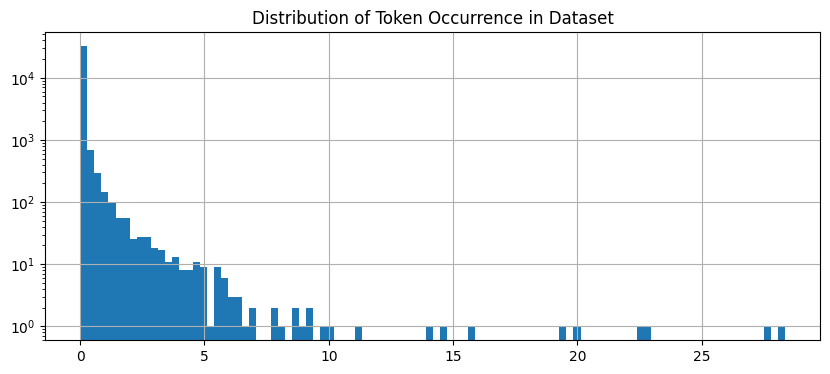

In [27]:
# Long tail of language
plt.figure(figsize=(10, 4))
(dtm_df.sum()/15000*100.0).hist(bins=100)
plt.yscale('log')
plt.title('Distribution of Token Occurrence in Dataset')
plt.show()

We have had to resort to using a log scale for the y-axis, since the distribution of tokens is so extremely skewed and following a power law. We could use this as a cumulative histogram to inform our cutoff choice of `min_df` for the CountVectorizer if we wanted to reduce memory usage.

As a result of doing the count vectorization, we get "free" text analytics - as we can calculate the total number of occurrences of each token by summing the counts for each column row-wise (as we did above). 

What are the 10 most frequently occurring tokens in the dataset?

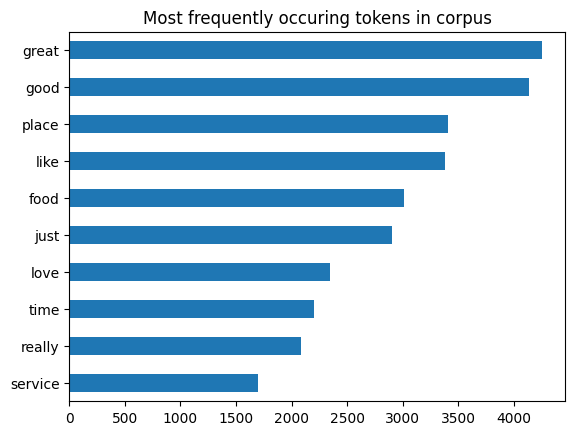

In [36]:
dtm_df.sum().nlargest(10).sort_values().plot(kind='barh')
plt.title('Most frequently occuring tokens in corpus')
plt.show()

That's interesting, but perhaps these tokens are not distributed across the different review types evenly. Let's instead look at the most frequently occurring tokens per source. To do this, we will use a pandas [groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html).

To do this, we need to add the `source` column to the document-term matrix dataframe. We should check if there is already a `source` column (as this could have appeared as a token in the dataset):

In [37]:
# CHECK if  there is a source column already in the dataframe
# as we do not want to overwrite it
dtm_df['source']

0        0
1        0
2        0
3        0
4        0
        ..
14995    0
14996    0
14997    0
14998    0
14999    0
Name: source, Length: 15000, dtype: int64

Indeed, there is! Perhaps we should use a more unique name like `review_source` - let's just quickly check it's not in the columns either:

In [38]:
sum(dtm_df.columns == 'review_source')

0

It is not. Finally, we check that the row count is the same between the document-term matrix dataframe `dtm_df` and the original dataframe with the `source` column, `df`, to make sure we are okay to append the latter to the former:

In [39]:
dtm_df.shape[0] == df.shape[0]

True

Ok, we can append the column:

In [40]:
# Append the source column onto the document term dataframe
dtm_df['review_source'] = df['source']

In [41]:
dtm_df['review_source']

0          yelp
1          yelp
2          yelp
3          yelp
4          yelp
          ...  
14995    amazon
14996    amazon
14997    amazon
14998    amazon
14999    amazon
Name: review_source, Length: 15000, dtype: object

Now we can group by review type and with a single line of code in pandas, calculate the total number of occurrences of each token by review type!

In [42]:
# Group by the review_source - sum the counts by token
grouped_sum = dtm_df.groupby('review_source').sum()
grouped_sum

,00,007,01,01042012,03342,039,050,06,07092008,075,...,äúshow,äúskills,äústar,äúthings,école,ém,ótimo,ôºå,única,único
review_source,,,,,,,,,,,,,,,,,,,,,
amazon,0,0,0,0,0,0,0,0,0,0,...,1,1,2,2,0,0,0,1,0,0
rottentomatoes,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
yelp,1,1,1,1,1,1,1,2,1,1,...,0,0,0,0,1,1,0,0,0,0


Finally, using a the powerful pandas [apply](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) method, and a *lambda function*, we can find the most frequently occurring tokens per review type:

In [43]:
grouped_sum.apply(lambda x: pd.Series(x.nlargest(25).index), axis=1).T

review_source,amazon,rottentomatoes,yelp
0,great,film,place
1,tablet,movie,good
2,love,like,food
3,use,story,great
4,easy,just,like
5,bought,good,just
6,kindle,characters,time
7,amazon,time,service
8,echo,comedy,really
9,good,films,dont


We can see that the Amazon reviews are mainly about electronics, RottenTomatoes mostly has movie words, and Yelp reviews mostly food and restaurant words, as would be expected.

Finally, we can pull out the entire rows in the lambda function, transpose the result, and plot:

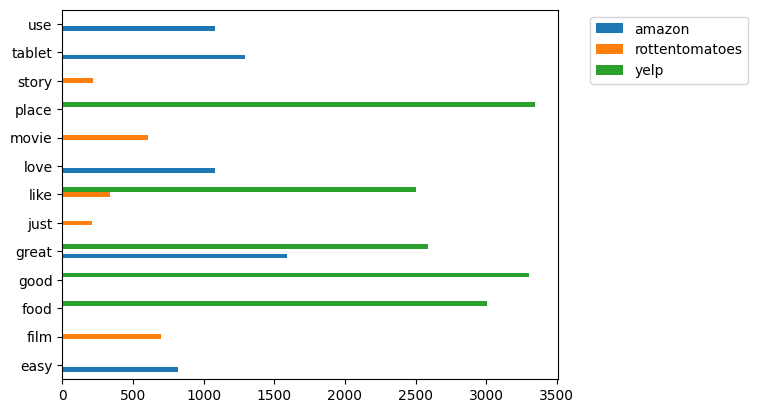

In [44]:
grouped_sum.apply(lambda x: pd.Series(x.nlargest(5)), axis=1).T.plot(kind='barh')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

We can see some words only occur frequently in a single category, whereas some others are frequently occurring in multiple review types (*e.g.* 'great', 'like').

Now we will drop t he review source column from our document-term matrix dataframe as we will be proceeding to doing machine learning and it is no longer required:

In [45]:
# Drop source from dtm_df
dtm_df.drop('review_source', axis=1, inplace=True)

In [50]:
# Check
'review_source' in dtm_df.columns

False

### Preprocessing the target column (`review`)

Now that we have preprocessed the reviews into numeric features for machine learning, we must also adddress the target column, `source`. Here we have a single column with values 'yelp', 'amazon', 'rottentomatoes' - we would like these to be integer values to represent categorical buckets (classes) for supervised learning - using a classification model.

One way to do this is using the `map` method from pandas and providing a dictionary to map the distinct values in the column to corresponding integer values:

In [51]:
# Method 1 - using pd.Series.map
df['source'].map({'yelp':0, 'rottentomatoes':1, 'amazon':2})

0        0
1        0
2        0
3        0
4        0
        ..
14995    2
14996    2
14997    2
14998    2
14999    2
Name: source, Length: 15000, dtype: int64

In [52]:
# Check
df['source'].map({'yelp':0, 'rottentomatoes':1, 'amazon':2}).value_counts()

source
0    5000
1    5000
2    5000
Name: count, dtype: int64

This is fine, because we know the distinct values which appear in our target column, and the number of distinct values (*i.e.* the cardinality of the target) is low (3). What if we don't know all the different values and/or there are a very large number of categories (*i.e.* the target has very high cardinality)? Here using the `map` function would be difficult or perhaps not possible.

Instead, this would be a case where we would use the `LabelEncoder` from scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

As with other 'transformer' type classes in sklearn, we instantiate and then call `fit_transform`:

In [53]:
# import
from sklearn.preprocessing import LabelEncoder

# instantiate
le = LabelEncoder()

# fit-transform
y = pd.Series(le.fit_transform(df['source']))

In [54]:
# Check
y

0        2
1        2
2        2
3        2
4        2
        ..
14995    0
14996    0
14997    0
14998    0
14999    0
Length: 15000, dtype: int32

The distinct classes found in the target column are stored in the `.classes_` attribute in the LabelEncoder:

In [55]:
le.classes_

array(['amazon', 'rottentomatoes', 'yelp'], dtype=object)

In [56]:
# Check
y.value_counts()

2    5000
1    5000
0    5000
Name: count, dtype: int64

## Machine Learning

Now that we've completed all the preprocessing we can move forward into the machine learning piece of the case study to build our MVP model. We have already created our target feature, `y`, above, and the document-term matrix dataframe will serve as our input features, `X`:

In [57]:
# Training data
X = dtm_df

# If on Colab Free or low resource machine, uncomment below
# Use original sparse document-term matrix for training
# X = dtm

# y is already assigned

Next, we split our data into training and test sets. Note that this is a naive approach, and more in-depth approaches such as [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) should be used, however this is fine for our MVP. Because we have a sizeable number of observations (15K), we can use a smaller test size - we choose 13.3% so that our train and test sets shake out to round numbers evenly:

In [58]:
# Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1333333)

Let's check the train and test set sizes:

In [59]:
# Check
X_train.shape

(13000, 33715)

In [60]:
X_test.shape

(2000, 33715)

In [61]:
print(f'{X_train.shape[0]*X_train.shape[1]:,}')

438,295,000


We have 13K reviews in the training set, and 2K in test. There are a total of ~438M elements in the training data! How large is the training data array in memory?

In [62]:
import sys

# Size of data in GB
sys.getsizeof(X_train)/(1024**3)

3.2656491100788116

The training data is ~3.3 GB! This may be challenging for lower-end machines or environments such as Google Colab free. Nonetheless, we press forward and fit our v0 model - the actual machine learning piece is very straightforward with only 3-4 lines of code, as we saw in [Section 3 of the course](https://nlpfor.me):

In [63]:
# ML
from sklearn.linear_model import LogisticRegression

# 1. Instantiate
logreg = LogisticRegression()

# 2. Fit
logreg.fit(X_train, y_train)

LogisticRegression()

We have fit a very simple 'vanilla' Logistic Regression model. Let's check for overfitting by evaluating on the training and test sets:

In [64]:
# 3. Evaluate
print(logreg.score(X_train, y_train))
print(logreg.score(X_test, y_test))

0.9966923076923077
0.972


While the training score is higher as to be expected, there is not a significant delta between train and test, so there is not extreme overfitting occurring which is good 👍

## Testing Our Model

Now that we have fit our MVP model, we can test on some new data from reviews which appeared on the website to "smoke test" and see if it performs as expected. Here is a sample of three reviews, in the restaurant, movie, and retail categories:

In [65]:
new_data = ['Absolutely loved this place! Would recommend!', \
            'Complete trash... avoid this film at all costs, I hate this director', \
            'Garbage product, screen did not power on, was a greasy film on the back immediately after I bought it. Will be returning it.']

We need to put this data through the same preprocessing as our training data to fit it into the model - *i.e.* clean / normalize, tokenize, remove stopwords, vectorize, etc.

Fortunately for us, we wrote a reusable function to do the former - so this is now just a simple function call passing in the data as a pandas Series:


In [66]:
# Create a pandas series
new_reviews = pd.Series(new_data)

# Test review function
new_reviews = preprocess_text(new_reviews)

new_reviews

0          absolutely loved this place would recommend
1    complete trash avoid this film at all costs i ...
2    garbage product screen did not power on was a ...
dtype: object

Great. Now we need to count vectorize the processed data using the originally fit count vectorizer, as our model expects numeric input with the 33,715 tokens (features) as from the original training data:

In [67]:
# Count vectorize - CV has already been fit
new_dtm = pd.DataFrame(cv.transform(new_reviews).toarray(), columns=cv.get_feature_names_out())

new_dtm

,00,007,01,01042012,03342,039,050,06,07092008,075,...,äúshow,äúskills,äústar,äúthings,école,ém,ótimo,ôºå,única,único
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Great! Now we can make predictions. The model returns the class labels (0,1,2) and we can convert these back to the text representations using the `inverse_transform` method in the LabelEncoder:

In [68]:
# So no we have the data in dtm form
# Get class labels and apply inverse transform to get ORIGINAL labels
le.inverse_transform(logreg.predict(new_dtm))

array(['yelp', 'rottentomatoes', 'amazon'], dtype=object)

It seems to be working well, as it has predicted the categories we expected. We can look in more detail at the model probabilities predicted by using `predict_proba` instead of `.predict`:

In [69]:
pd.DataFrame(logreg.predict_proba(new_dtm), columns=le.classes_)

,amazon,rottentomatoes,yelp
0,0.111143,0.028364,0.860493
1,0.000286,0.999051,0.000663
2,0.878006,0.121334,0.000660


We can see that the model is extremely confident (~99.9%) that the second review is a movie review, but less confident in the predictions of reviews 1 & 3. Likely there is some ambiguity in review #3, as words like 'film' and 'screen' would also appear in movie reviews.

## Model introspection

Finally, we can perform model introspection to look at what the model has learned. For Logistic Regression, this means looking at the relative sizes and signs of the coefficients as they related to the different tokens which are predictive of each class.

Since we had 3 classes and 33,715 features, the coffiecients array stored in `.coef_` in the fitted Logistic Regression model has these dimensions. We can nicely put this into a pandas dataframe using the labels from the CountVectorizer and LabelEncoder to make clear:

In [70]:
coef_df = pd.DataFrame(logreg.coef_.T, columns=le.classes_, index=cv.get_feature_names_out())
coef_df

,amazon,rottentomatoes,yelp
00,-0.000958,-0.000332,0.001290
007,-0.010189,0.023619,-0.013430
01,0.000004,0.000005,-0.000009
01042012,-0.000501,-0.000036,0.000537
03342,0.000005,0.000005,-0.000010
...,...,...,...
ém,0.000001,0.000004,-0.000005
ótimo,-0.009188,0.013575,-0.004387
ôºå,0.000000,0.000000,0.000000
única,-0.016219,0.023045,-0.006827


We can then visualize this with some matplotlib code to see which tokens are most predictive of each class:

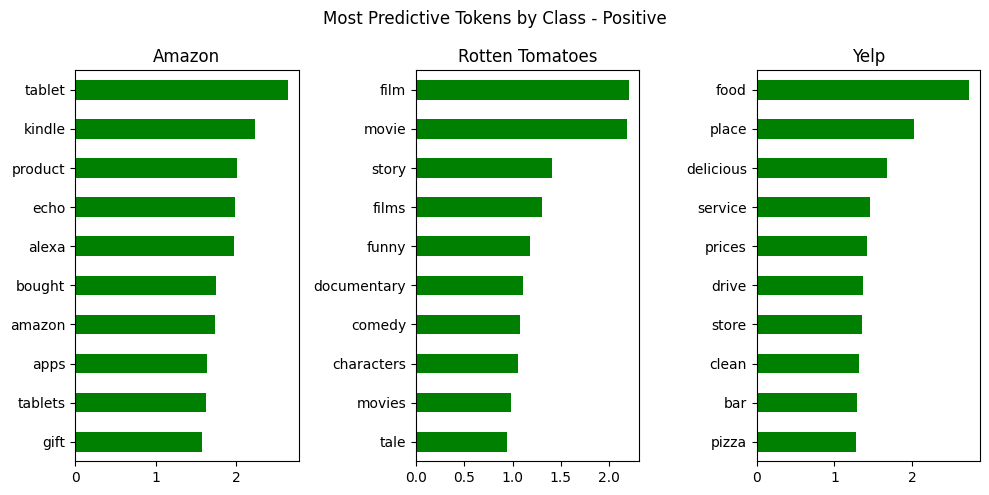

In [71]:
plt.subplots(1, 3, figsize=(10, 5))

plt.suptitle('Most Predictive Tokens by Class - Positive')

plt.subplot(1,3,1)
coef_df['amazon'].nlargest(10).sort_values(ascending=True).plot(kind='barh', color='green')
plt.title('Amazon')

plt.subplot(1,3,2)
coef_df['rottentomatoes'].nlargest(10).sort_values(ascending=True).plot(kind='barh', color='green')
plt.title('Rotten Tomatoes')

plt.subplot(1,3,3)
coef_df['yelp'].nlargest(10).sort_values(ascending=True).plot(kind='barh', color='green')
plt.title('Yelp')

plt.tight_layout()

As we might expected, words like 'alexa', 'tablet', and 'kindle' are highly predictive of the Amazon class, whereas words like 'food', 'place' and 'delicious' are of the Yelp class, and "movie-like" words of the RottenTomatoes class. This makes sense, and also reflects the qualitities of the training data.

Are there any issues with our model, however? What if we look at the most negatively predictive features (tokens) by class?

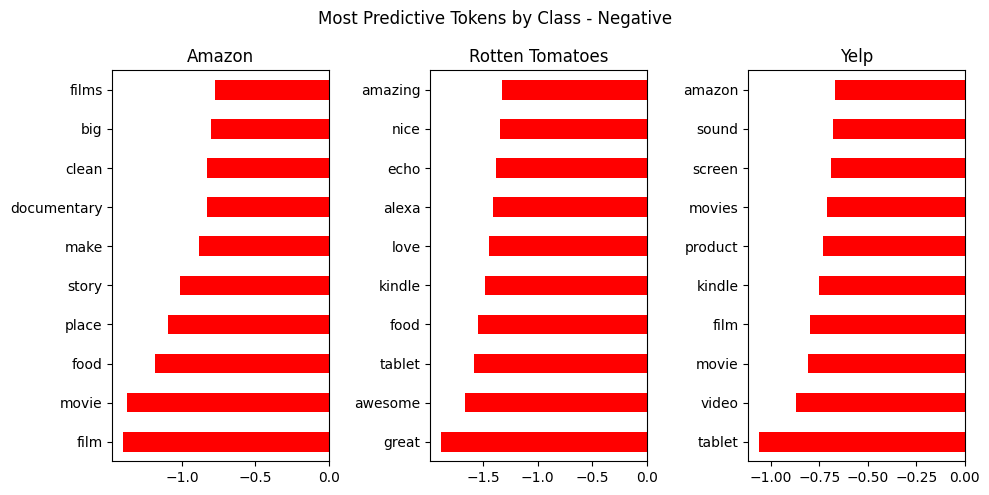

In [72]:
plt.subplots(1, 3, figsize=(10, 5))

plt.suptitle('Most Predictive Tokens by Class - Negative')

plt.subplot(1,3,1)
coef_df['amazon'].nsmallest(10).sort_values(ascending=True).plot(kind='barh', color='red')
plt.title('Amazon')

plt.subplot(1,3,2)
coef_df['rottentomatoes'].nsmallest(10).sort_values(ascending=True).plot(kind='barh', color='red')
plt.title('Rotten Tomatoes')

plt.subplot(1,3,3)
coef_df['yelp'].nsmallest(10).sort_values(ascending=True).plot(kind='barh', color='red')
plt.title('Yelp')

plt.tight_layout()

We can see that the words which are positively predictive for one class are generally in the list of most negatively predictively for the other classes (as each review must belong to one of the three classes). This reflects the nature (bias) of our training data set. From this learning in the MVP, it might make more sense to build a system with individual models for predicting each class if the number of classes is low, or to try using a dataset with a larger number of categories for tagging the site reviews with and see if these issues are addressed in the model training.

<div align="right" float="right"><a href="https://www.github.com/nlpfromscratch/nlpfor.me" style="float: right; text-align: right; text-decoration: none; color: black">NLPfor.me 🔠⚡🤖🧠😃</a>